In [1]:
import numpy as np
import pandas as pd
from plotnine import *

# Generate Random Data
data = np.random.normal(3, 10, 30000)
print("Number of Samples: ", len(data))
print("Mean: ", np.mean(data))
print("STD: ", np.std(data))

Number of Samples:  30000
Mean:  2.9575849891077866
STD:  10.002652758312419


In [5]:
# Take Sample 
np.random.shuffle(data)
samples = data[0:5000]
print(len(samples))

5000


We accept new set of parameters only if the likelihood of the data given the new set of parameters is more than that of previous set of parameters. For a given data point, we can compute probability density as follows:
$$ P(d_i|\mu, \sigma) = \frac{1}{\sigma\sqrt(2\pi)}e^{-\frac{(d_i-\mu)^2}{2\sigma^2}}$$

Assuming independence between sampled data point, then $P(D|\mu, \sigma)$ is given as:

$$P(D|\mu, \sigma) = \prod_i{\frac{1}{\sigma\sqrt(2\pi)}e^{-\frac{(Di-\mu)^2}{2\sigma^2}}}$$

For numerical stablity, let's take log of it, i.e.

$$log(P(D|\mu, \sigma)) = \sum_i{\left[-log(\sigma\sqrt{2\pi}) - \frac{(d_i - \mu)^2}{\sigma^2})\right]}$$
$$log(P(D|\mu, \sigma)) = -nlog(\sigma\sqrt{2\pi}) - \sum_i{\frac{(d_i - \mu)^2}{\sigma^2}}$$




In [46]:
import random

def likelihood(data, mu, sigma, **kwargs):
    v1 = len(data) * np.log(sigma * np.sqrt(2 * np.pi))
    v2 = np.sum(np.square(data - mu)/(2 * sigma * sigma))
    return - (v1 + v2)
        
def prior(mu, sigma):
    if(sigma <= 0 or mu <= 0):
        return 0
    return 1


def acceptance(p_old, p_new):
    return (np.exp(p_new-p_old)) > random.random()


def transition(mu, sigma):
    new_mu = np.random.normal(mu, 0.1, size=1)[0]
    new_sigma = np.random.normal(sigma, 0.5, size=1)[0]
    return (new_mu, new_sigma)



In [47]:
from tqdm import tqdm, trange
def metropolis_hastings(data, mu, sigma, iterations=10000):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    logs = []
    p_old = likelihood(data, mu, sigma) + np.log(prior(mu, sigma))
    
    for i in trange(iterations):
        
        x_new =  transition(mu, sigma)    
        p_new = likelihood(data, x_new[0], x_new[1]) + np.log(prior(*x_new))
        
        if acceptance(p_old, p_new):
            mu, sigma = x_new
            p_old = p_new
            status='accepted'
        else:
            status='rejected'
        
        logs.append([i, x_new[0], x_new[1], status, p_new])
                
    df = pd.DataFrame(logs, columns=['iter', 'mu', 'sigma', 'status', 'posterior'])
    df['status'] = pd.Categorical(df['status'])
    return df


logs = metropolis_hastings(samples, 2, 8, iterations=100000)

100%|██████████| 100000/100000 [00:03<00:00, 25056.52it/s]


In [48]:
logs.groupby('status').size()

status
accepted    20991
rejected    79009
dtype: int64

In [32]:
logs[(logs.status=='accepted') & (logs.iter < 30000)].shape

(6241, 5)

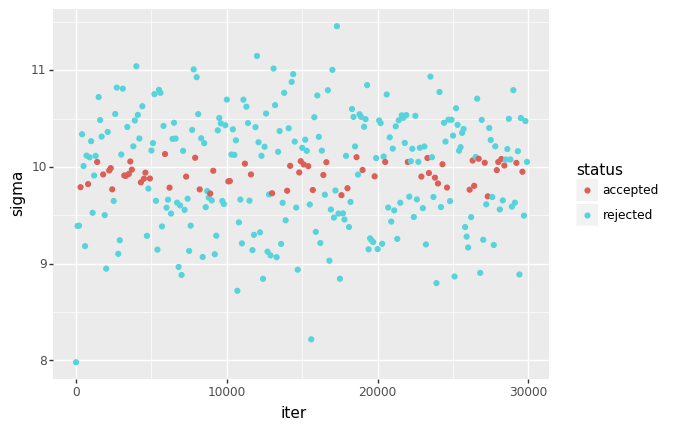

<ggplot: (7549804513)>

In [9]:
from plotnine import *
(
    ggplot(logs[logs['iter'] % 100 == 0], aes(x='iter', y='sigma'))
    + geom_point(aes(colour='status'))
)

In [80]:
logs[(logs.status=='accepted') & (logs.iter > 10000)].mean()

iter         2.001895e+04
mu           7.463837e+00
sigma        6.241157e+01
posterior   -2.535034e+06
dtype: float64

In [33]:
acceptedDF = logs[logs.status=='accepted'].copy()

In [35]:
n = acceptedDF.shape[0]
lastP75 = int(n * 0.75)
acceptedDF.sort_values('iter').tail(lastP75)[['mu', 'sigma']].describe()

,mu,sigma
count,4680.000000,4680.000000
mean,3.021811,9.918626
std,0.138894,0.115106
min,2.603273,9.528012
25%,2.927881,9.836767
50%,3.023677,9.915726
75%,3.112551,9.998521
max,3.482781,10.339311


In [4]:
np.exp(x - y)

0.8130081300813015